In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

/home/fm-pc-lt-238/miniconda3/envs/demand/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Dataset

In [2]:
file_path = "Business_Performance_09-01-2025_09-30-2025_10-09-2025_13-16-30.xlsx"

In [4]:
df = pd.read_excel(file_path, sheet_name=0)
df.head()

,Date Range,Revenue,Orders,Units Sold,Customer Visits,Conversion Rate
0,09/01/2025,32971.54,65,73,9151,0.005901
1,09/02/2025,30084.17,70,83,7275,0.006048
2,09/03/2025,3555.82,41,41,6250,0.003040
3,09/04/2025,7172.08,42,42,6124,0.003266
4,09/05/2025,4593.71,36,36,5709,0.003854


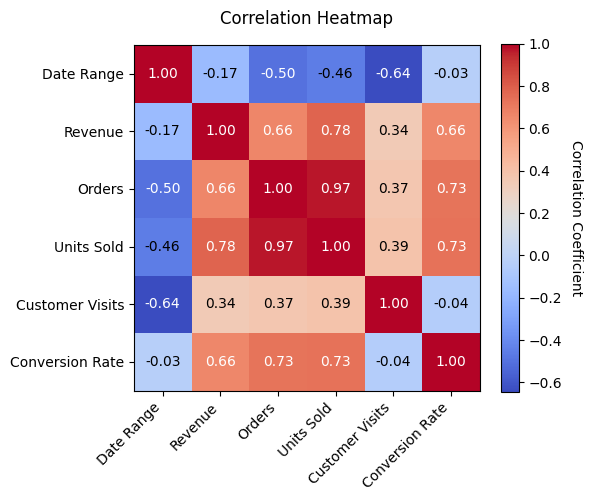

In [10]:
corr = df.corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, cmap='coolwarm', interpolation='nearest')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=15)

# Set ticks and labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# Annotate correlation values
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha='center', va='center',
                color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')

ax.set_title('Correlation Heatmap', pad=15)
plt.tight_layout()
plt.show()

## Data cleaning and preprocessing
Prophet needs columns:
- ds → date column
- y → target column (here “Units Sold”)

In [5]:
# Clean column names
df.columns = df.columns.str.strip()

# Convert 'Date Range' to datetime
df['Date Range'] = pd.to_datetime(df['Date Range'])

# Remove $ and , from Revenue
df['Revenue'] = df['Revenue'].replace(r'[\$,]', '', regex=True).astype(float)

# Remove % from Conversion Rate
df['Conversion Rate'] = df['Conversion Rate'].replace(r'[%]', '', regex=True).astype(float) / 100

# Select only needed columns for Prophet
df_prophet = df[['Date Range', 'Units Sold']].rename(columns={'Date Range': 'ds', 'Units Sold': 'y'})


In [6]:
df_prophet.head()

,ds,y
0,2025-09-01,73
1,2025-09-02,83
2,2025-09-03,41
3,2025-09-04,42
4,2025-09-05,36


## Visualize the time series

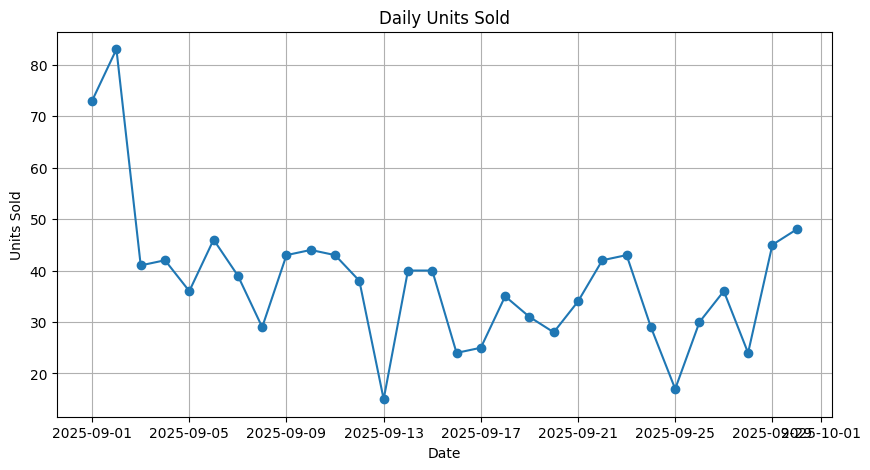

In [7]:
plt.figure(figsize=(10,5))
plt.plot(df_prophet['ds'], df_prophet['y'], marker='o')
plt.title("Daily Units Sold")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.show()


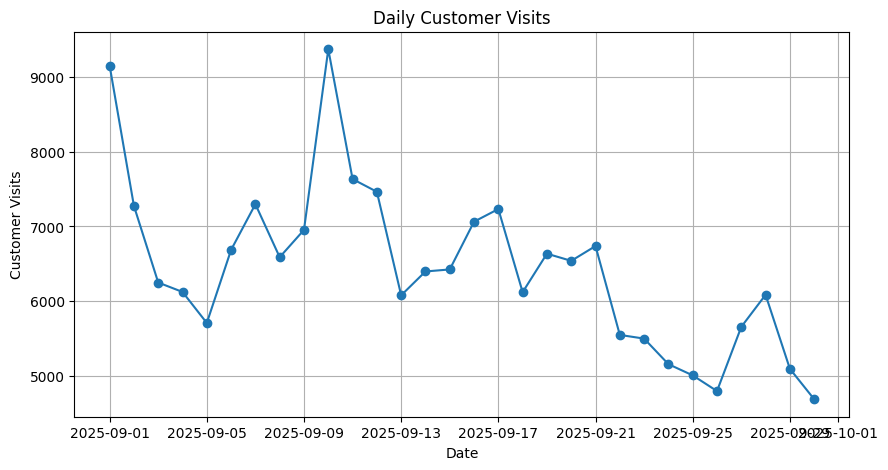

In [99]:
plt.figure(figsize=(10,5))
plt.plot(df_prophet['ds'], df_prophet['Customer Visits'], marker='o')
plt.title("Daily Customer Visits")
plt.xlabel("Date")
plt.ylabel("Customer Visits")
plt.grid(True)
plt.show()

## Fit Prophet model

In [ ]:
# Initialize and fit prophet
model = Prophet()
model.add_seasonality(name="weekly", period=7, fourier_order=2)
model.fit(df_prophet)

16:38:02 - cmdstanpy - INFO - Chain [1] start processing


16:38:02 - cmdstanpy - INFO - Chain [1] done processing


## Make future predictions

In [21]:
# Create future dataframe
future = model.make_future_dataframe(periods=15)  # 15 days ahead

# Predict
forecast = model.predict(future)

# View results
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)


,ds,yhat,yhat_lower,yhat_upper
30,2025-10-01,24.366219,11.270324,37.670973
31,2025-10-02,20.323799,6.443393,33.262183
32,2025-10-03,22.320212,9.204188,34.646489
33,2025-10-04,18.867895,5.265558,31.410615
34,2025-10-05,21.088384,8.634471,33.379772
35,2025-10-06,32.194670,18.953725,46.306281
36,2025-10-07,31.820998,18.420472,46.271247
37,2025-10-08,19.398731,6.377766,32.412972
38,2025-10-09,15.356311,1.467310,28.201912
39,2025-10-10,17.352723,4.941025,29.995018


## Visualize the forecast

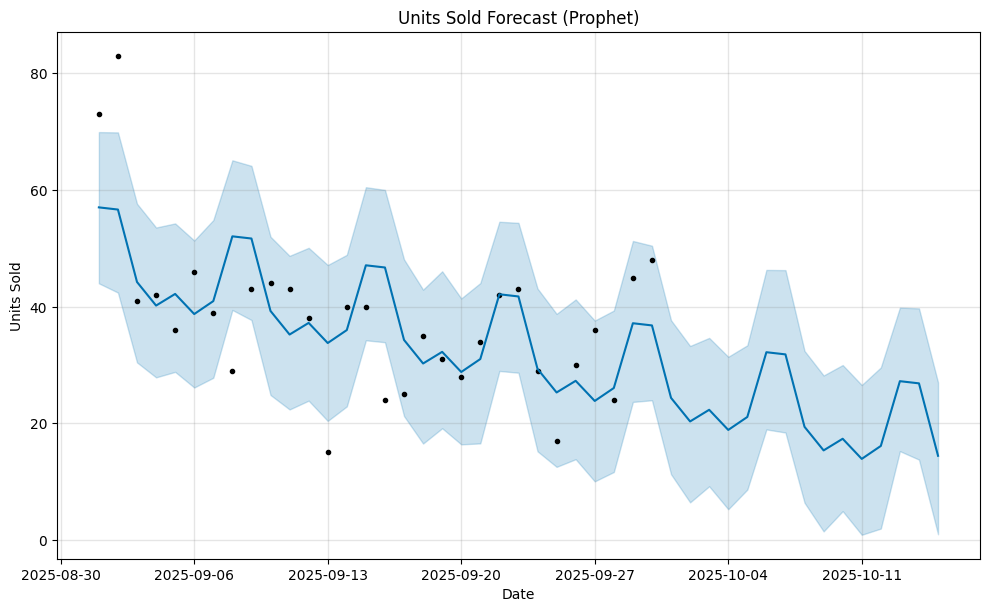

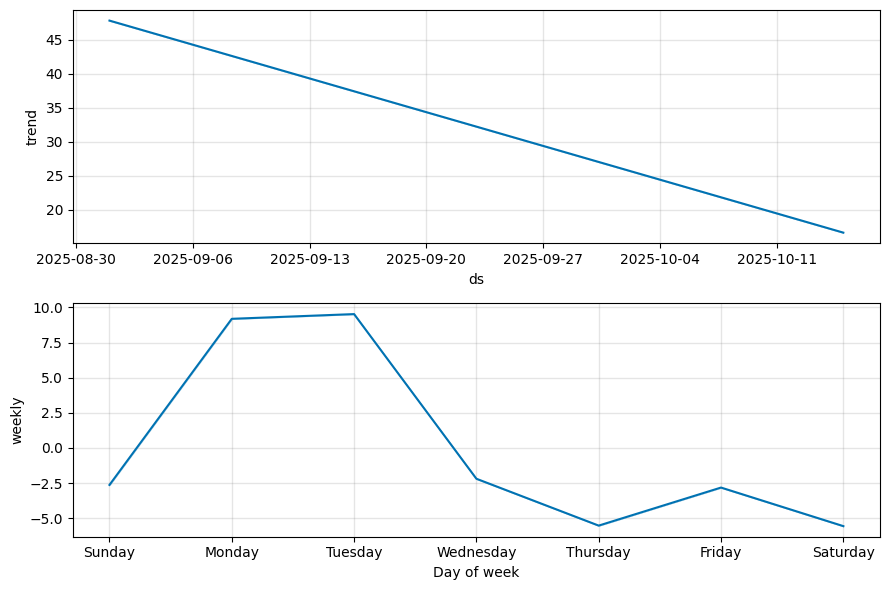

In [22]:
# Plot forecast
model.plot(forecast)
plt.title("Units Sold Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()

# Plot trend and seasonality components
model.plot_components(forecast)
plt.show()


## Split data

In [66]:
df_prophet = df[['Date Range', 'Units Sold', "Customer Visits"]].rename(columns={'Date Range': 'ds', 'Units Sold': 'y'})

# Split dataset
train = df_prophet.iloc[:25]  # first 25 days
test = df_prophet.iloc[25:]   # last 5 days

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (25, 3)
Test shape: (5, 3)


## Fit Prophet on training set

In [77]:
# Initialize and fit model on training data
model = Prophet() # default seasonality of fourier_order=3
model.fit(train)

model_with_seasonality = Prophet()
model_with_seasonality.add_seasonality(name="weekly", period=7, fourier_order=2)
model_with_seasonality.fit(train)

model_extra_feat = Prophet() # default seasonality of fourier_order=3
model_extra_feat.add_regressor('Customer Visits')
model_extra_feat.fit(train)

18:27:15 - cmdstanpy - INFO - Chain [1] start processing
18:27:15 - cmdstanpy - INFO - Chain [1] done processing
18:27:15 - cmdstanpy - INFO - Chain [1] start processing
18:27:15 - cmdstanpy - INFO - Chain [1] done processing
18:27:15 - cmdstanpy - INFO - Chain [1] start processing
18:27:15 - cmdstanpy - INFO - Chain [1] done processing


## Create future dataframe for test period

In [88]:
test

,ds,y,Customer Visits
0,2025-09-26,30,4798
1,2025-09-27,36,5657
2,2025-09-28,24,6086
3,2025-09-29,45,5096
4,2025-09-30,48,4689


In [91]:
# Forecast for the test period (next 5 days)
future_test = model.make_future_dataframe(periods=len(test), freq='D')
forecast_test = model.predict(future_test)

# Keep only test period predictions
predictions = forecast_test[['ds', 'yhat']].iloc[-len(test):]
predictions.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Combine actual vs predicted
results = test.copy()
results['yhat'] = predictions['yhat']

###################### model with custom seasonality ###########################
future_test = model_with_seasonality.make_future_dataframe(periods=len(test), freq='D')
forecast_test_seasonality = model_with_seasonality.predict(future_test)

# Keep only test period predictions
predictions = forecast_test_seasonality[['ds', 'yhat']].iloc[-len(test):]
predictions.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Combine actual vs predicted
# results = test.copy()
results['yhat_seasonality'] = predictions['yhat']

###################### model with extra features ###########################
future_test = model_extra_feat.make_future_dataframe(periods=len(test), freq='D')[-len(test):]
future_test.reset_index(drop=True, inplace=True)
future_test["Customer Visits"] = test["Customer Visits"]
forecast_extra_feat = model_extra_feat.predict(future_test)

# Keep only test period predictions
predictions = forecast_extra_feat[['ds', 'yhat']].iloc[-len(test):]
predictions.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Combine actual vs predicted
# results = test.copy()
results['yhat_customer_visits'] = predictions['yhat']

print(results)

          ds   y  Customer Visits       yhat  yhat_seasonality  \
0 2025-09-26  30             4798  19.045367         19.318715   
1 2025-09-27  36             5657  13.712099         15.220543   
2 2025-09-28  24             6086  21.712025         19.544721   
3 2025-09-29  45             5096  26.057274         28.580134   
4 2025-09-30  48             4689  28.307280         26.304370   

   yhat_customer_visits  
0             16.598267  
1             14.441773  
2             22.590033  
3             24.282326  
4             25.979116  


## Calculate metrics: MAE, RMSE, RMSLE

In [93]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual and predicted values
y_true = results['y']
y_pred = results['yhat']

y_pred_seasonality = results['yhat_seasonality']
y_pred_extra_feat = results['yhat_customer_visits']


# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Metrics Seasonality
mae_seasonality = mean_absolute_error(y_true, y_pred_seasonality)
rmse_seasonality = mean_squared_error(y_true, y_pred_seasonality)
rmsle_seasonality = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred_seasonality)))

# Metrics Extra Feature
mae_extra_feat = mean_absolute_error(y_true, y_pred_extra_feat)
rmse_extra_feat = mean_squared_error(y_true, y_pred_extra_feat)
rmsle_extra_feat = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred_extra_feat)))

metrics_df = pd.DataFrame({
    'MAE': [mae, mae_seasonality, mae_extra_feat],
    'RMSE': [rmse, rmse_seasonality, rmse_extra_feat],
    'RMSLE': [rmsle, rmsle_seasonality, rmsle_extra_feat]
}, index=['Default', 'Seasonality', 'Extra_Feature'])

metrics_df

# print(f"MAE: {mae:.2f}")
# print(f"RMSE: {rmse:.2f}")
# print(f"RMSLE: {rmsle:.4f}")

# print(f"MAE Seasonality: {mae_seasonality:.2f}")
# print(f"RMSE Seasonality: {rmse_seasonality:.2f}")
# print(f"RMSLE Seasonality: {rmsle_seasonality:.4f}")


,MAE,RMSE,RMSLE
Default,14.833191,273.723892,0.564915
Seasonality,14.806304,261.207514,0.535524
Extra_Feature,15.821697,312.098592,0.600317


## Plot actual vs predicted

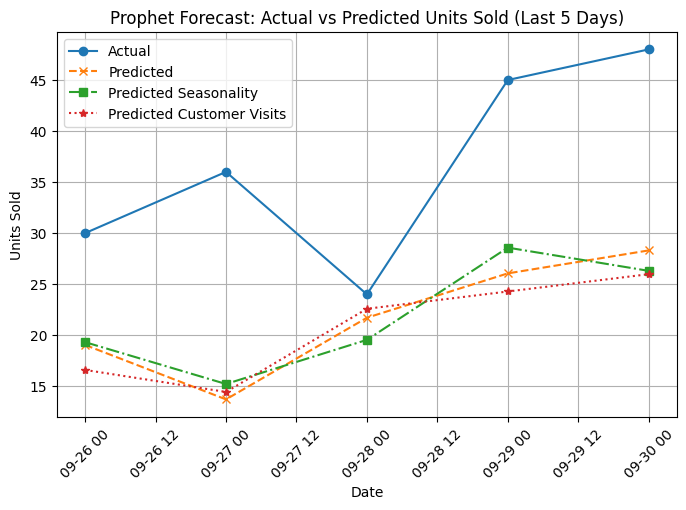

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(results['ds'], results['y'], marker='o', label='Actual')
plt.plot(results['ds'], results['yhat'], marker='x', linestyle='--', label='Predicted')
plt.plot(results['ds'], results['yhat_seasonality'], marker='s', linestyle='-.', label='Predicted Seasonality')
plt.plot(results['ds'], results['yhat_customer_visits'], marker='*', linestyle=':', label='Predicted Customer Visits')

plt.title("Prophet Forecast: Actual vs Predicted Units Sold (Last 5 Days)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()